In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import preprocessing

import math

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from random import shuffle

In [2]:
music_df = pd.read_csv('../music_data/billboard_top_100_1960_1969.csv', na_values=['NA'])

In [3]:
music_df.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount
count,1000.000000,1000,1000,1000.000000,1.000000e+03
unique,NaN,547,987,NaN,NaN
top,NaN,The Beatles,If I Had A Hammer,NaN,NaN
freq,NaN,23,2,NaN,NaN
mean,50.547000,NaN,NaN,1964.501000,7.899716e+06
std,28.922799,NaN,NaN,2.875111,1.992259e+07
min,1.000000,NaN,NaN,1960.000000,1.554000e+03
25%,25.750000,NaN,NaN,1962.000000,2.437070e+05
50%,50.500000,NaN,NaN,1964.500000,8.641245e+05
75%,76.000000,NaN,NaN,1967.000000,4.963935e+06


# 1. Visualization

## 1.1 Correlation Analysis

In [4]:
# Pearson correlation analysis
correlation = music_df.corr(method='pearson')
correlation

,Rank,Year,SpotifyPlayCount
Rank,1.000000,0.002575,-0.162270
Year,0.002575,1.000000,0.166069
SpotifyPlayCount,-0.162270,0.166069,1.000000


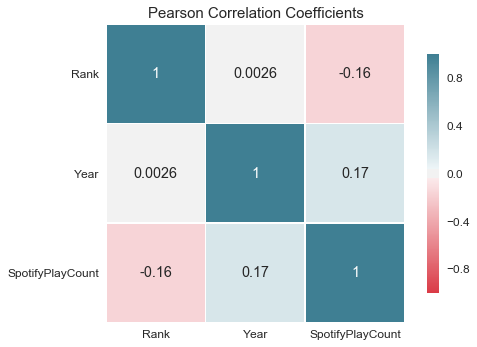

In [5]:
sns.set(style="white", font_scale=1.2)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Plot the Pearson correlation heatmap
ax = sns.heatmap(correlation, cmap=cmap, annot=True, center=0, 
                 square=True, linewidths=.7, cbar_kws={"shrink": .8})
plt.yticks(rotation=0) 
ax.set_title('Pearson Correlation Coefficients', fontsize=15)

plt.savefig('../figure/correlation_heatmap.png')

In [6]:
# Pearson correlation analysis - log(SpotifyPlayCount)
music_df_logtarget = music_df.copy()
music_df_logtarget.SpotifyPlayCount = np.log(music_df_logtarget.SpotifyPlayCount)
correlation = music_df_logtarget.corr(method='pearson')
correlation

,Rank,Year,SpotifyPlayCount
Rank,1.000000,0.002575,-0.266992
Year,0.002575,1.000000,0.271174
SpotifyPlayCount,-0.266992,0.271174,1.000000


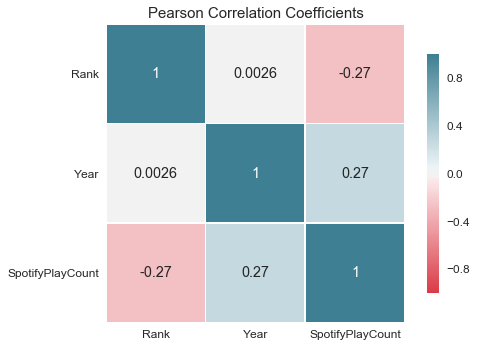

In [7]:
sns.set(style="white", font_scale=1.2)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Plot the Pearson correlation heatmap
ax = sns.heatmap(correlation, cmap=cmap, annot=True, center=0, 
                 square=True, linewidths=.7, cbar_kws={"shrink": .8})
plt.yticks(rotation=0) 
ax.set_title('Pearson Correlation Coefficients', fontsize=15)

plt.savefig('../figure/correlation_heatmap_logtarget.png')

## 1.2 Plots

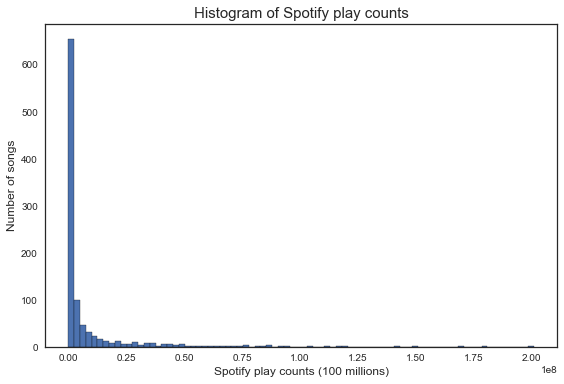

Mean:  7899715.501
Std:  19922589.896896116


In [8]:
# Plot . Histogram of SpotifyPlayCounts
sns.set(style="white")

num_bins = 80
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(music_df.SpotifyPlayCount, num_bins, edgecolor='black')

ax.set_xlabel('Spotify play counts (100 millions)', fontsize=12)
ax.set_ylabel('Number of songs', fontsize=12)
ax.set_title('Histogram of Spotify play counts', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', music_df.SpotifyPlayCount.mean())
print('Std: ', music_df.SpotifyPlayCount.std())

fig.savefig('../figure/hist_spotifyplaycount.png')

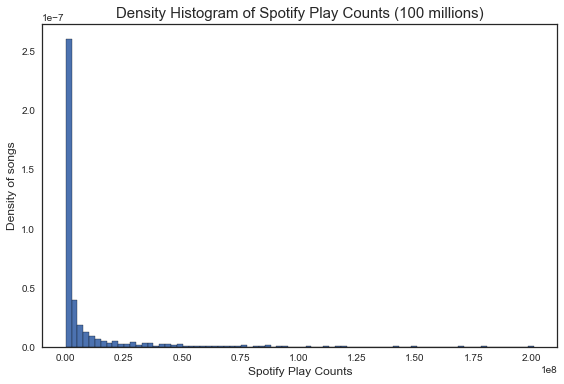

Mean:  7899715.501
Std:  19922589.896896116


In [9]:
# Plot . Density Histogram of SpotifyPlayCounts
sns.set(style="white")

num_bins = 80
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(music_df.SpotifyPlayCount, num_bins, normed=True, edgecolor='black')

ax.set_xlabel('Spotify Play Counts', fontsize=12)
ax.set_ylabel('Density of songs', fontsize=12)
ax.set_title('Density Histogram of Spotify Play Counts (100 millions)', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', music_df.SpotifyPlayCount.mean())
print('Std: ', music_df.SpotifyPlayCount.std())

fig.savefig('../figure/hist_density_spotifyplaycount.png')

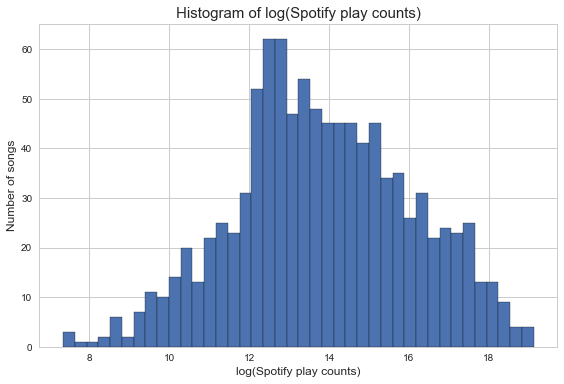

Mean:  13.84261285102407
Std:  2.213413059222591


In [10]:
# Plot . Histogram of log(SpotifyPlayCounts)
sns.set(style="whitegrid")

num_bins = 40
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(np.log(music_df.SpotifyPlayCount), num_bins, edgecolor='black')

ax.set_xlabel('log(Spotify play counts)', fontsize=12)
ax.set_ylabel('Number of songs', fontsize=12)
ax.set_title('Histogram of log(Spotify play counts)', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', np.log(music_df.SpotifyPlayCount).mean())
print('Std: ', np.log(music_df.SpotifyPlayCount).std())

fig.savefig('../figure/hist_log_spotifyplaycount.png')

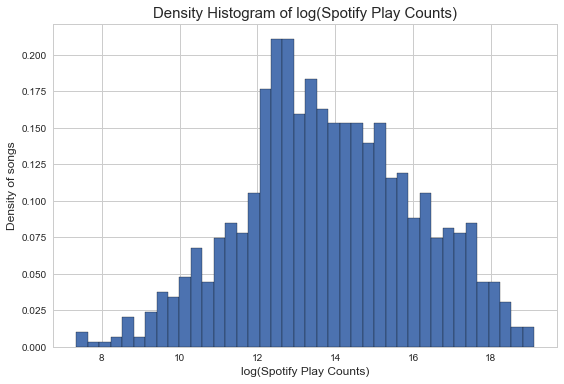

Mean:  13.84261285102407
Std:  2.213413059222591


In [11]:
# Plot . Density Histogram of log(SpotifyPlayCounts)
sns.set(style="whitegrid")

num_bins = 40
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(np.log(music_df.SpotifyPlayCount), num_bins, normed=True, edgecolor='black')

ax.set_xlabel('log(Spotify Play Counts)', fontsize=12)
ax.set_ylabel('Density of songs', fontsize=12)
ax.set_title('Density Histogram of log(Spotify Play Counts)', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', np.log(music_df.SpotifyPlayCount).mean())
print('Std: ', np.log(music_df.SpotifyPlayCount).std())

fig.savefig('../figure/hist_density_log_spotifyplaycount.png')

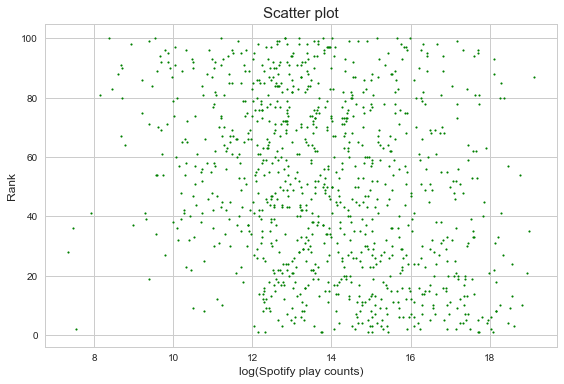

In [12]:
# Plot . Scatter plot of Rank and log(SpotifyPlayCounts)
sns.set(style="whitegrid")

fig = plt.figure()
ax = plt.subplot()
ax.scatter(np.log(music_df.SpotifyPlayCount), music_df.Rank, 
           s=3, color='green')

ax.set_xlabel('log(Spotify play counts)', fontsize=12)
ax.set_ylabel('Rank', fontsize=12)
ax.set_title('Scatter plot', fontsize=15)

plt.tight_layout()
plt.show()

fig.savefig('../figure/scatter_logspotifyplaycount_rank.png')

In [13]:
# Find a song with the highest Spotify play counts
music_df.SpotifyPlayCount.max()
music_df.loc[music_df['SpotifyPlayCount'] == music_df.SpotifyPlayCount.max()]

,Rank,Artist,Title,Year,SpotifyPlayCount
786,87,Marvin Gaye and Tammi Terrell,Ain't No Mountain High Enough,1967,201057355


# 2 Data scraping

## Extract artist data

In [38]:
# Extract Artist column - File 'billboard_artist_name.csv'
artist_df = pd.DataFrame(music_df.Artist.unique())
artist_df.columns = ['Artist']

In [40]:
artist_df.to_csv('../music_data/billboard_artist_name.csv', sep=',', index=False)

## wikipedia package (python)

python code : wikipedia_scrape_wordcount.py

# 3. Model

## 3.1 Preprocessing

In [14]:
# Read artist dataset
artist_df = pd.read_csv('../music_data/billboard_artist_wordcount.csv', na_values=['NA'])

In [15]:
artist_df.describe(include='all')

,Artist,WikiWordCount
count,547,547.000000
unique,547,NaN
top,The 5th Dimension,NaN
freq,1,NaN
mean,NaN,2166.974406
std,NaN,2617.383243
min,NaN,108.000000
25%,NaN,651.000000
50%,NaN,1278.000000
75%,NaN,2541.000000


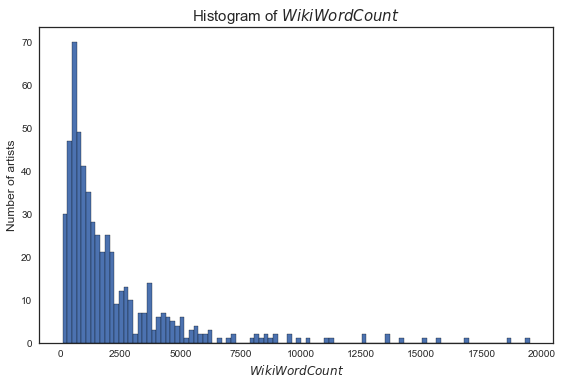

Mean:  2166.9744058500914
Std:  2617.383243489533


In [16]:
# Plot . Histogram of Wikipedia word count
sns.set(style="white")

num_bins = 100
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(artist_df.WikiWordCount, num_bins, edgecolor='black')

ax.set_xlabel('$WikiWordCount$', fontsize=12)
ax.set_ylabel('Number of artists', fontsize=12)
ax.set_title('Histogram of $WikiWordCount$', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', artist_df.WikiWordCount.mean())
print('Std: ', artist_df.WikiWordCount.std())

fig.savefig('../figure/hist_wikiwordcount.png')

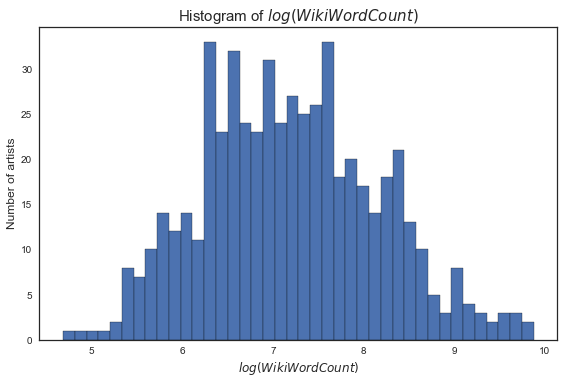

Mean:  7.199045109926113
Std:  0.9639198424125061


In [17]:
# Plot . Histogram of log(WikipediaWordCount)
sns.set(style="white")

num_bins = 40
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(np.log(artist_df.WikiWordCount), num_bins, edgecolor='black')

ax.set_xlabel('$log(WikiWordCount)$', fontsize=12)
ax.set_ylabel('Number of artists', fontsize=12)
ax.set_title('Histogram of $log(WikiWordCount)$', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', np.log(artist_df.WikiWordCount).mean())
print('Std: ', np.log(artist_df.WikiWordCount).std())

fig.savefig('../figure/hist_log_wikiwordcount.png')

In [18]:
music_dataset = pd.merge(music_df_logtarget, artist_df, on='Artist')
music_dataset.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
count,1000.000000,1000,1000,1000.000000,1000.000000,1000.000000
unique,NaN,547,987,NaN,NaN,NaN
top,NaN,The Beatles,I Like It Like That,NaN,NaN,NaN
freq,NaN,23,2,NaN,NaN,NaN
mean,50.547000,NaN,NaN,1964.501000,13.842613,3361.737000
std,28.922799,NaN,NaN,2.875111,2.213413,3937.524284
min,1.000000,NaN,NaN,1960.000000,7.348588,108.000000
25%,25.750000,NaN,NaN,1962.000000,12.403722,951.000000
50%,50.500000,NaN,NaN,1964.500000,13.669471,1942.500000
75%,76.000000,NaN,NaN,1967.000000,15.417700,4194.000000


In [19]:
# Pearson correlation analysis
correlation = music_dataset.corr(method='pearson')
correlation

,Rank,Year,SpotifyPlayCount,WikiWordCount
Rank,1.000000,0.002575,-0.266992,-0.037377
Year,0.002575,1.000000,0.271174,0.118884
SpotifyPlayCount,-0.266992,0.271174,1.000000,0.462173
WikiWordCount,-0.037377,0.118884,0.462173,1.000000


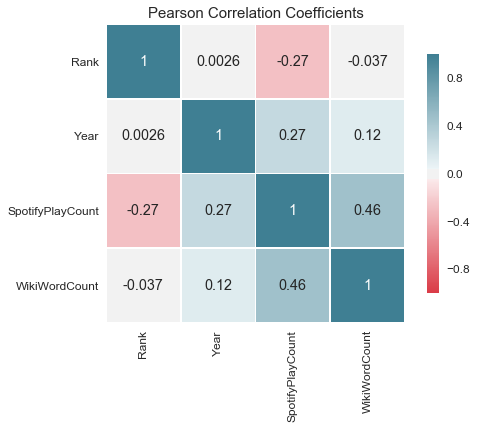

In [20]:
sns.set(style="white", font_scale=1.2)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Plot the Pearson correlation heatmap
ax = sns.heatmap(correlation, cmap=cmap, annot=True, center=0, 
                 square=True, linewidths=.7, cbar_kws={"shrink": .8})
plt.yticks(rotation=0) 
ax.set_title('Pearson Correlation Coefficients', fontsize=15)

plt.savefig('../figure/correlation_heatmap_logtarget_wwc.png')

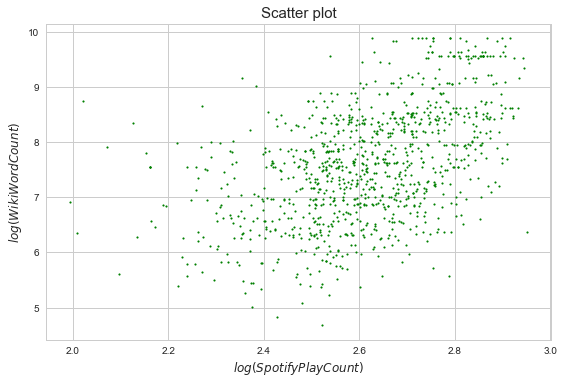

In [21]:
# Plot . Scatter plot of WikiWordCount and log(SpotifyPlayCounts)
sns.set(style="whitegrid")

fig = plt.figure()
ax = plt.subplot()
ax.scatter(np.log(music_dataset.SpotifyPlayCount), np.log(music_dataset.WikiWordCount), 
           s=3, color='green')

ax.set_xlabel('$log(SpotifyPlayCount)$', fontsize=12)
ax.set_ylabel('$log(WikiWordCount)$', fontsize=12)
ax.set_title('Scatter plot', fontsize=15)

plt.tight_layout()
plt.show()

fig.savefig('../figure/scatter_logspotifyplaycount_logwikiwc.png')

In [22]:
music_dataset_norm = music_dataset.copy()

In [23]:
music_dataset_norm.WikiWordCount = np.log(music_dataset_norm.WikiWordCount)

In [24]:
def z_score_norm(df, feature_list):
    """ Dot the z-score method on selected features in feature_list. 
        z = (x - mean)/std
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())

In [25]:
z_score_norm(music_dataset_norm, feature_list=['Rank','Year','WikiWordCount'])

In [26]:
music_dataset_norm.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
count,1.000000e+03,1000,1000,1.000000e+03,1000.000000,1.000000e+03
unique,NaN,547,987,NaN,NaN,NaN
top,NaN,The Beatles,I Like It Like That,NaN,NaN,NaN
freq,NaN,23,2,NaN,NaN,NaN
mean,2.797762e-17,NaN,NaN,1.023182e-14,13.842613,8.594347e-15
std,1.000000e+00,NaN,NaN,1.000000e+00,2.213413,1.000000e+00
min,-1.713078e+00,NaN,NaN,-1.565505e+00,7.348588,-2.788130e+00
25%,-8.573513e-01,NaN,NaN,-8.698794e-01,12.403722,-6.998582e-01
50%,-1.625016e-03,NaN,NaN,-3.478126e-04,13.669471,-1.425531e-02
75%,8.800324e-01,NaN,NaN,8.691837e-01,15.417700,7.246168e-01


## 3.2  Baseline Model - Linear regression

In [51]:
feature_base = music_dataset_norm.loc[:,['Rank','Year']]
target = music_dataset_norm.loc[:,'SpotifyPlayCount']

In [52]:
linear_regr_base = linear_model.LinearRegression()

In [55]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    
#     fig.savefig('../figure/%s_stat_table.png' % model_name)

In [84]:
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    err = pred - target   # error is a Series
    min_err = err.min()
    max_err = err.max()
    fig = plt.figure()
    ax = err.plot.hist(bins=20, figsize=(7,7), edgecolor='black')
    ax.set_xticks(np.arange(math.floor(min_err), math.ceil(max_err)))
    ax.set_title('%s - Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()
    
    fig.savefig('../figure/%s_error_dist.png' % model_name)

In [88]:
def permutation_test(model_name, model, feature, target, pred):
    '''do permuation tests
    
    Args:
        model_name: model
        feature (DataFrame): feature data
        target (Series):  target data
        pred   (ndarray): predition results
    ''' 
    #pred = cross_val_predict(model, X=feature, y=target, cv=10)
    mae = mean_absolute_error(target, pred)
    mae_list = [mae]
    count = 0
    while count<100:
        count=count+1 
        target_to_list=target.tolist()
        shuffle(target_to_list)
        target_per = pd.DataFrame({'playcount':target_to_list})
        pred1 = cross_val_predict(model, X=feature, y=target_per, cv=10)
        mae_shuffle=mean_absolute_error(target,pred1)
        mae_list.append(mae_shuffle)
    num_bins = 20
    fig, ax = plt.subplots(figsize=(7,7))
    n, bins, patches = ax.hist(mae_list, num_bins, edgecolor='black')
    ax.set_title('%s - Permutation Test' % model_name, fontsize=18)
    #ax.set_xlabel('$Log(playcount)-mae$', fontsize=14)
    ax.set_xlabel('Target - Mean Absolute Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.get_children()[0].set_color('r')
    ax.grid()
    
    fig.savefig('../figure/%s_permutation.png' % model_name)

In [82]:
def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    #plt.scatter(target, pred, edgecolor='black', s=15)
    plt.scatter(target, pred, s=13)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    #ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_xlabel('Target', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()
    
    fig.savefig('../figure/%s_error_map.png' % model_name)

In [72]:
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        4) permutation test
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
    permutation_test(model_name, model, feature, target, pred)
    
    performance_statistics(model_name, target, pred)

This is the plots/reports of LinearRegression


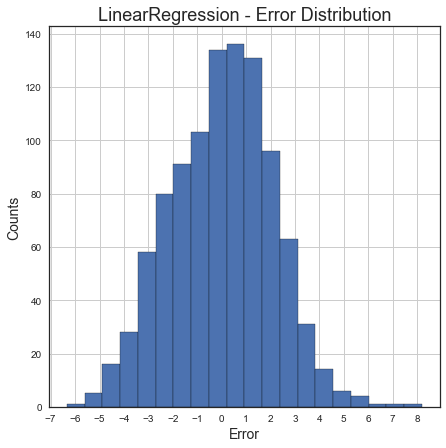

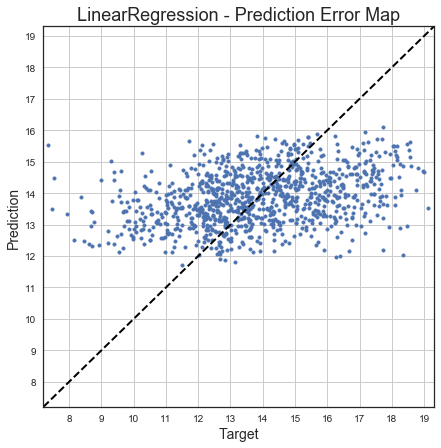

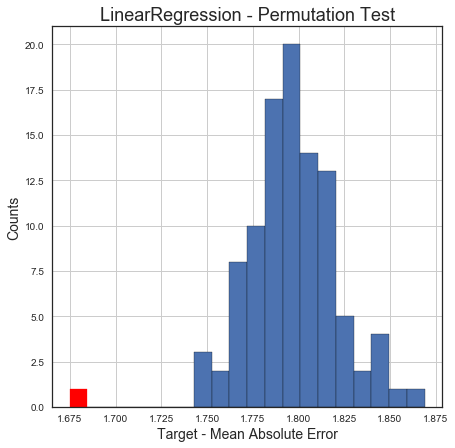

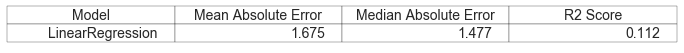

In [89]:
sns.set(style="white")
evaluation(linear_regr_base, feature_base, target)

## 3.3  Advanced Model - Linear regression

In [90]:
feature = music_dataset_norm.loc[:,['Rank','Year','WikiWordCount']]
target = music_dataset_norm.loc[:,'SpotifyPlayCount']

In [91]:
linear_regr_adv = linear_model.LinearRegression()

This is the plots/reports of LinearRegression


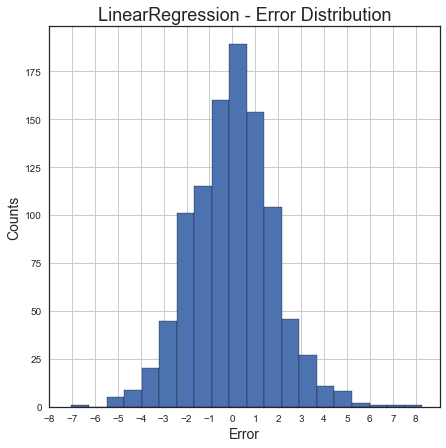

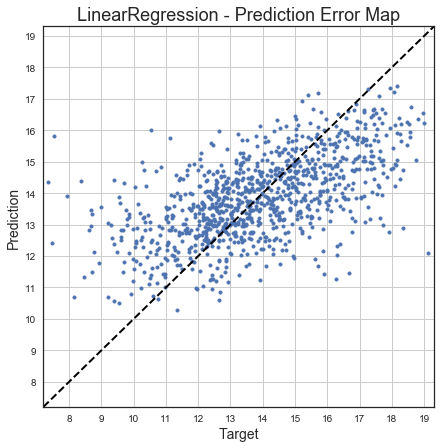

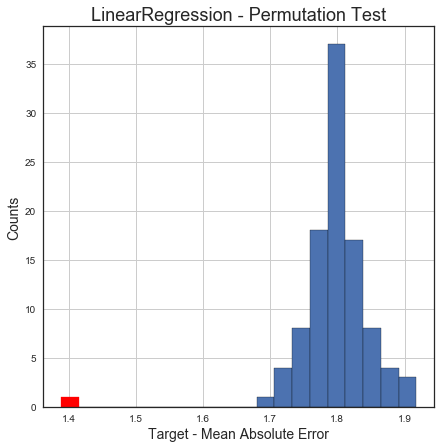

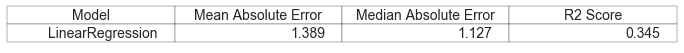

In [92]:
sns.set(style="white")
evaluation(linear_regr_adv, feature, target)

## 3.4 Advanced Model - Support Vector Regression

In [49]:
svr_poly = SVR(kernel='linear', C=1e3)

This is the plots/reports of SVR


/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/haenalee/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

KeyboardInterrupt: 

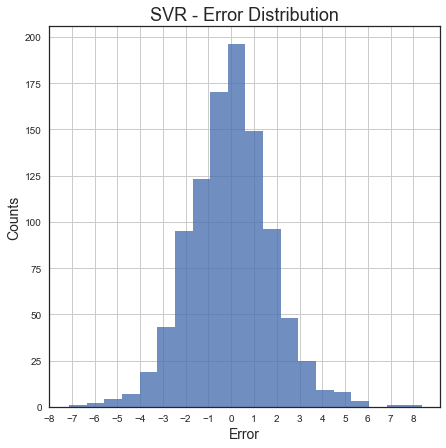

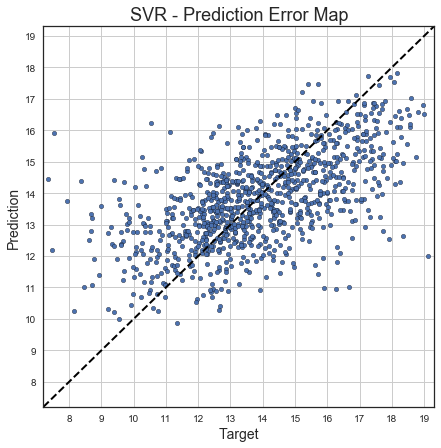

In [50]:
evaluation(svr_poly, feature, target)

In [40]:
#artist_df = pd.read_csv('../music_data/billboard_artist_name.csv', na_values=['NA'])
music_corgis_df = pd.read_csv('../../../Project/music_corgis.csv', na_values=['NA'])

result = pd.merge(music_df, music_corgis_df, how='left', 
                  left_on=['Artist','Title'], right_on=['artist.name','title'])

In [204]:
# result

In [42]:
music_corgis_join = result
music_corgis_join.to_csv('../music_data/music_corgis_join_artist-title.csv', sep=',', index=False)

In [43]:
result = pd.merge(music_df, music_corgis_df, how='left', 
                  left_on='Artist', right_on='artist.name')

In [205]:
# result

In [45]:
music_corgis_join = result
music_corgis_join.to_csv('../music_data/music_corgis_join_artist.csv', sep=',', index=False)

# Wikipedia Scraping (BeautifulSoup)

In [1]:
import bs4
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

my_url = 'https://en.wikipedia.org/wiki/Barry_Sadler'
# Open up connection, grab the page
uClient = uReq(my_url)
page_html = uClient.read()
uClient.close()

# html parsing
page_soup = soup(page_html, "html.parser")
page_soup.h1

<h1 class="firstHeading" id="firstHeading" lang="en">Barry Sadler</h1>

In [23]:
# Grab each product
#containers = page_soup.findAll("div", {"class":"item-container"})
#containers = page_soup.findAll("div", {"class":"mw-body-content"})
containers = page_soup.findAll("div", {"class":"mw-content-ltr"})
len(containers)

1

In [38]:
containers[0].div.p

<p><b>Barry Allen Sadler</b> (November 1, 1940 – November 5, 1989) was an American <a class="mw-redirect" href="/wiki/United_States_Military" title="United States Military">military veteran</a>, singer/songwriter and author. Sadler served as a <a class="mw-redirect" href="/wiki/United_States_Army_Special_Forces" title="United States Army Special Forces">Green Beret</a> medic, achieving the rank of <a class="mw-redirect" href="/wiki/Staff_Sergeant#United_States" title="Staff Sergeant">Staff Sergeant</a>. He served in the Vietnam War from late December 1964 to late May 1965. Most of his work has a military theme, and he is best known for his "<a href="/wiki/Ballad_of_the_Green_Berets" title="Ballad of the Green Berets">Ballad of the Green Berets</a>," the No. 1 pop song of 1966.</p>

In [39]:
info_table = page_soup.findAll("table", {"class":"infobox vcard"})
info_table

[<table class="infobox vcard" style="width:22em;width:315px;border-spacing:2px;">
 <tr>
 <th colspan="2" style="text-align:center;font-size:125%;font-weight:bold;background-color:#B0C4DE;"><span class="fn">Barry Sadler</span></th>
 </tr>
 <tr>
 <td colspan="2" style="text-align:center;border-bottom: 1px solid #aaa;; line-height: 1.5em"><a class="image" href="/wiki/File:Barry_Sadler.png"><img alt="Barry Sadler.png" data-file-height="494" data-file-width="494" height="220" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/220px-Barry_Sadler.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/330px-Barry_Sadler.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/440px-Barry_Sadler.png 2x" width="220"/></a>
 <div style="font-size: 100%">Barry Sadler in 1966</div>
 </td>
 </tr>
 <tr>
 <th scope="row" style="padding-right: 1em">Born</th>
 <td><span style="display:none">(<span class="bday">1940-11-01</span>)</spa

In [42]:
info_table[0]

<table class="infobox vcard" style="width:22em;width:315px;border-spacing:2px;">
<tr>
<th colspan="2" style="text-align:center;font-size:125%;font-weight:bold;background-color:#B0C4DE;"><span class="fn">Barry Sadler</span></th>
</tr>
<tr>
<td colspan="2" style="text-align:center;border-bottom: 1px solid #aaa;; line-height: 1.5em"><a class="image" href="/wiki/File:Barry_Sadler.png"><img alt="Barry Sadler.png" data-file-height="494" data-file-width="494" height="220" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/220px-Barry_Sadler.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/330px-Barry_Sadler.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/440px-Barry_Sadler.png 2x" width="220"/></a>
<div style="font-size: 100%">Barry Sadler in 1966</div>
</td>
</tr>
<tr>
<th scope="row" style="padding-right: 1em">Born</th>
<td><span style="display:none">(<span class="bday">1940-11-01</span>)</span>November 1

In [52]:
info_table[0].text

'\n\nBarry Sadler\n\n\n\nBarry Sadler in 1966\n\n\n\nBorn\n(1940-11-01)November 1, 1940\nCarlsbad, New Mexico, U.S.\n\n\nDied\nNovember 5, 1989(1989-11-05) (aged\xa049)\nMurfreesboro, Tennessee, U.S.\n\n\nAllegiance\n\xa0United States of America\n\n\nService/branch\n\xa0United States Air Force (1958-1962)\n\xa0United States Army (1962-1967)\n\n\nYears\xa0of service\n1958-1967\n\n\nRank\n Staff Sergeant\n\n\nUnit\n U.S. Army Special Forces - 7th Special Forces Group (Airborne)\n\n\nBattles/wars\nVietnam War\n\n'

In [56]:
info_table[0].th.span.text

'Barry Sadler'

In [66]:
info_table[0]

<table class="infobox vcard" style="width:22em;width:315px;border-spacing:2px;">
<tr>
<th colspan="2" style="text-align:center;font-size:125%;font-weight:bold;background-color:#B0C4DE;"><span class="fn">Barry Sadler</span></th>
</tr>
<tr>
<td colspan="2" style="text-align:center;border-bottom: 1px solid #aaa;; line-height: 1.5em"><a class="image" href="/wiki/File:Barry_Sadler.png"><img alt="Barry Sadler.png" data-file-height="494" data-file-width="494" height="220" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/220px-Barry_Sadler.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/330px-Barry_Sadler.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/440px-Barry_Sadler.png 2x" width="220"/></a>
<div style="font-size: 100%">Barry Sadler in 1966</div>
</td>
</tr>
<tr>
<th scope="row" style="padding-right: 1em">Born</th>
<td><span style="display:none">(<span class="bday">1940-11-01</span>)</span>November 1

In [ ]:
product_name.replace(",", "|")